<a href="https://colab.research.google.com/github/rafaeldsouza/mestrado/blob/main/Redes%20Neurais/backward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize
from scipy.special import expit
from sklearn.model_selection import train_test_split

In [9]:

def criaDataset(n=1000):
  x,y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
  y = np.array(y%2, dtype=int)
  return x,y
  
X,y = criaDataset()


In [10]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

In [18]:
def define_axes(X):
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-.1, max1+.1, min2-.1, max2+.1]
    
def plot_predictions(clf, X):
    axes = define_axes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

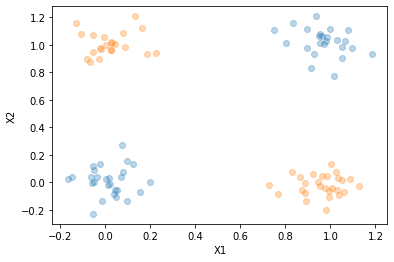

In [12]:
plotDataSet(Xtr, ytr)

In [13]:
from scipy.special import expit

def tanh(a):
    return expit(a)*2-1

from abc import ABC, abstractstaticmethod

class ActivationFunction(ABC):
    @abstractstaticmethod
    def forward(a):
        pass
    @abstractstaticmethod
    def backward(a):
        pass
    @abstractstaticmethod
    def decision(a):
        pass

class Tanh(ActivationFunction):
    @staticmethod
    def forward(a):
        return expit(a) * 2 - 1
    @staticmethod
    def backward(a):
        return (1 - np.square(Tanh.forward(a)))
    @staticmethod
    def decision(a):
        return (a >= 0) * 2 - 1

class Sigmoid(ActivationFunction):
    @staticmethod
    def forward(a):
        return expit(a)
    @staticmethod
    def backward(a):
        return Sigmoid.forward(a)*(1-Sigmoid.forward(a))
    @staticmethod
    def decision(a):
        return (a >= 0.5) * 2 - 1

def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X), axis=1)
    return Xb

class Backpropagation():
    def __init__(self, n_hidden=10, activation=Tanh()):
        self.n_hidden = n_hidden
        self.activation = activation
        self.learning_rate = 0.001
        self.max_iter = 1000
    
    def forward(self, X):
        self.Xb = includebias(X)
        self.pH = self.Xb @ self.wih
        self.H = self.activation.forward(self.pH)
        self.Hb = includebias(self.H)
        self.prey = self.Hb @ self.who
        self.posy = self.activation.forward(self.prey)
        self.ypred = self.activation.decision(self.posy)
        return self.ypred

    def backward(self, y):
        ho_delta = y - self.ypred
        ho_grad = self.Hb.T @ ho_delta
        deriv_grad = self.activation.backward(self.pH) 
        ih_delta = (ho_delta @ self.who[1:,:].T) * deriv_grad
        ih_grad = self.Xb.T @ ih_delta
        self.who += ho_grad * self.learning_rate
        self.wih += ih_grad * self.learning_rate
    
    def fit(self, X, y):
        self.wih = np.random.uniform(-1, 1, size=(X.shape[1]+1, self.n_hidden))
        self.who = np.random.uniform(-1, 1, size=(self.n_hidden+1, y.shape[1]))
        for _ in range(self.max_iter):
            self.forward(X)
            self.backward(y)
    
    def predict(self, X):
        return self.forward(X)


In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class MLP(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm=Backpropagation()):
        self.training_algorithm = training_algorithm

    def encode_labels(self, y):
        self.labels = list(set(y))
        return label_binarize(y, classes=self.labels)*2-1

    def fit(self, X, y):
        yhot = self.encode_labels(y)
        self.training_algorithm.fit(X, yhot)

    def predict(self, X):
        a = self.training_algorithm.predict(X)
        if len(self.labels) <= 2:
            idx = np.array(a > 0, dtype=int).reshape((-1,))
        else:
            idx = np.argmax(a, axis=1) 
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

In [15]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

1.0
0.9955555555555555


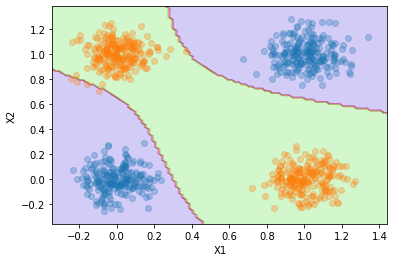

1.0
0.9933333333333333


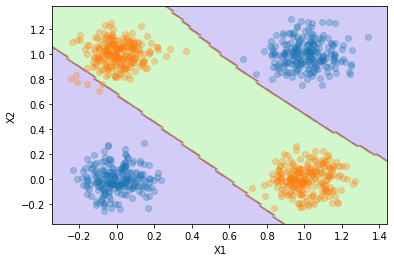

In [19]:
for f in [Tanh(), Sigmoid()]:
    mlp = MLP(Backpropagation(activation=f))
    mlp.fit(Xtr, ytr)
    print(accuracy(ytr, mlp.predict(Xtr)))
    print(accuracy(yte, mlp.predict(Xte)))
    plotDataSet(Xte, yte)
    plot_predictions(mlp, Xte)
    plt.show()